# BilbyAnalysis.ipynb

Maria Okounkova (mokounkova@flatironinstitute.org)

### Notebook for the analysis of Bilby runs, including corner plots and evidences

### Imports

In [6]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import corner
from astropy import constants as const
from math import pi

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

### Functions for injection values, Bayes factors, evidences, etc

In [19]:
LabelDict = {'chirp_mass' : r"$\mathcal{M} [M_\odot]$", 'mass_ratio' : r"$q$", \
             'a_1' : r"$a_1$", 'a_2' : r"$a_2$", 'luminosity_distance' : r"$d_L$ [mpc]", \
            'dec' : 'dec', 'ra' : 'ra', 'theta_jn' : r"$\theta_{jn}$", 'tilt_1' : r"$\theta_1$", \
            'tilt_2' : r"$\theta_2$", 'psi' : r"$\psi$", 'phase' : r'$\Delta \phi$'}
    
def GetTruthDict(p):
    """ Return a dictionary of truth values for corner plots from the parameters.json file 
        corresponding to the injected parameters, where p is the path to the file """
    TruthDict = {}
    
    f = open(p + '/parameters.json')
    params = json.load(f)
    TruthDict['chirp_mass'] = params['chirp_mass']
    TruthDict['mass_ratio'] = params['mass_ratio']
    TruthDict['mass'] = params['mass']
    TruthDict['luminosity_distance'] = params['dist_mpc']
    TruthDict['a_1'] = np.abs(params['a_1'][2]) ## assumes aligned spin for now
    TruthDict['a_2'] = np.abs(params['a_2'][2])
    TruthDict['dec'] = params['dec']
    TruthDict['ra'] = params['ra']
    TruthDict['theta_jn'] = params['theta']
    TruthDict['tilt_1'] = 0.0
    TruthDict['tilt_2'] = np.pi
    TruthDict['phase'] = params['phi']
    TruthDict['psi'] = params['pol'] 
    f.close()
    return TruthDict

def Evidence(p):
    """ Return the log evidence for a given bilby run
        located in directory p """
    f = open(p + 'outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_evidence']

def EvidenceErr(p):
    """ Return the error on the log evidence for a given bilby run 
        located in directory p """
    f = open(p + 'outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_evidence_err']

def BayesFactor(p):
    """ Return the log Bayes factor for a given bilby run 
        located in directory p """
    f = open(p + 'outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_bayes_factor']

def EvidenceAndBayes(p):
    """ Return the log Bayes factor, log evidence, and log evidence error
        for a given bilby run located in directory p """
    f = open(p + 'outdir/fast_tutorial_result.json')
    data = json.load(f)
    f.close()
    return data['log_bayes_factor'], data['log_evidence'], data['log_evidence_err']
    
def EvidenceAndBayesArray(p_array):
    """ Return the log Bayes factor, log evidence, and log evidence error
        for a set of bilby runs located in directories given in p_array """
    bfs = []
    evs = []
    ev_errs = []
    for p in p_array:
        bf, ev, ev_err = EvidenceAndBayes(p)
        print(f, bf)
        bfs.append(bf)
        evs.append(ev)
        ev_errs.append(ev_err)
    return bfs, evs, ev_errs

def GetPosterior(p, quantity):
    """ Return the posterior for a given bilby run
        for a given quantity, such as mass_ratio, 
        chirp_mass, a_1, a_2, etc"""
    f = open(p + '/fast_tutorial_result.json')
    data = json.load(f)
    vals = data['posterior']['content'][quantity]
    f.close()
    return vals

def EllinKm(ell_string, mass):
    """ For dCS parameters, convert from the string corresponding
        to the dimensionless ell value (like `0p0`) to a value
        in kilometers (like 0.0 [km]) """
    ell = float(ell_string.replace('p', '.'))
    mass_msun = mass * const.M_sun
    phys_ell_km = ell * mass_msun * const.G /(const.c**2) / 1000
    return phys_ell_km.value



### Plot Bayes factors and evidences for Bilby runs

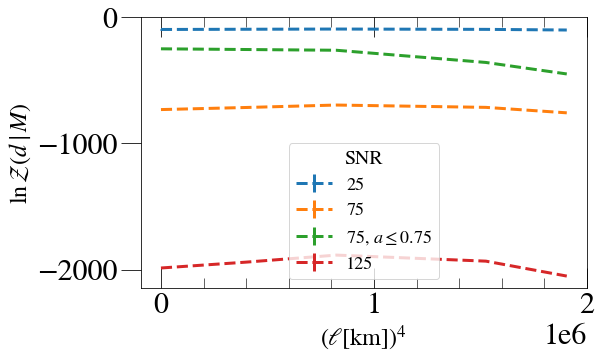

In [49]:
# plt.figure(figsize=(8, 5))
# plt.plot(ell_km, bf_25, '--o', lw = 3.0, label = '25')
# plt.plot(ell_km, bf_75, '--o', lw = 3.0, label = '75')
# plt.plot(ell_km_lower, bf_75_lower, '--o', lw = 3.0, label = '75, $a \leq 0.75$')
# plt.plot(ell_km, bf_125, '--o', lw = 3.0, label = '125')
# plt.xlabel(r'$(\ell [\mathrm{km}])^4$')
# plt.ylabel(r'$\ln$ Bayes Factor')
# legend = plt.legend(title = 'SNR')
# plt.setp(legend.get_title(),fontsize=20)

# plt.figure(figsize=(8, 5))
# plt.errorbar(ell_km, ev_25, ev_err_25, ls = '--', lw = 3.0, label = '25')
# plt.errorbar(ell_km, ev_75, ev_err_75, ls = '--', lw = 3.0, label = '75')
# plt.errorbar(ell_km_lower, ev_75_lower, ev_err_75_lower, ls = '--', lw = 3.0, label = '75, $a \leq 0.75$')
# plt.errorbar(ell_km, ev_125, ev_err_125, ls = '--', lw = 3.0, label = '125')
# #plt.plot(ell_km, ev_75, 'o', color = '#40916b')
# plt.xlabel(r'$(\ell [\mathrm{km}])^4$')
# plt.ylabel(r'$\ln \,\mathcal{Z} (d \mid M)$')
# legend = plt.legend(title = 'SNR')
# plt.setp(legend.get_title(),fontsize=20)
# plt.show()

### Corner plot for GR injections with various SNRs

In [ ]:
def SNRCornerPlot():
    
    ## Quantities to plot
    quants = ['mass_ratio', 'chirp_mass', 'a_1', 'a_2']
    #quants = ['dec', 'ra', 'luminosity_distance']
    q_range = [(0.25, 1.0), (20, 40), (0.0, 1.0), (0.0, 1.0)]
    #q_range = [(0, 2*pi), (0, 2*pi), (200, 500)]
    labels = [LabelDict[q] for q in quants]
    dim = len(quants) 

    snr_values = ["25", "75", "125"]
    cs = sns.color_palette('husl', n_colors=len(snr_values) + 1)

    fig, ax_arr = plt.subplots(dim, dim, figsize=(10,10))
    x = [0.0, 0.0]
    y = [0.0, 0.0]

    ## Get true values
    p = '../BilbyPE/dCS_0p0_25/'
    TruthDict = GetTruthDict(p) ## for now
    truths = [TruthDict[q] for q in quants]

    handles = []
    
    ## Plot for SNR values
    for SNR, color in zip(snr_values, cs[1:]):

        p = '../BilbyPE/dCS_0p0_' + SNR + '/'
        vals = np.vstack([GetPosterior(p + 'outdir', q) for q in quants]).transpose()

        corner.corner(vals, fig=fig, labels=labels,
                     title_kwargs={"fontsize": 20}, label_kwargs={"fontsize": 20}, color=color, 
                      show_titles=False, smooth = 2.0, range = q_range, truths = truths, truth_color = 'black')

        l = ax_arr[0][dim-1].plot(x, y, label=SNR, color = color)
        handles.append(l[0])


    ## add in the legend
    legend = ax_arr[0][dim-1].legend(handles=handles, frameon=False, title = r'SNR in H1', loc = 'upper center')
    plt.setp(legend.get_title(),fontsize=20)
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12, length=6)
    plt.tight_layout()
    plt.savefig('SNRCornerPlot.pdf')
    plt.show()
    
#SNRCornerPlot()  

### Corner plot for injections with various priors

In [2]:
def PriorsCornerPlot():
    
    ## Quantities to plot
    #quants = ['ra', 'dec', 'luminosity_distance']
    #q_range = [(0, 2*pi), (-pi, pi), (300, 500)]
    #quants = ['psi', 'phase', 'luminosity_distance']
    #q_range = [(0, 2*pi), (0, 2*pi), (300, 500)]
    #quants = ['ra', 'dec'] #, 'luminosity_distance']
    #q_range = [(0, 2*pi), (-pi, pi)] #, (200, 500)]
    quants = ['mass_ratio', 'chirp_mass', 'a_1', 'a_2']
    q_range = [(0.2, 1.0), (25, 40), (0.0, 1.0), (0.0, 1.0)]
    labels = [LabelDict[q] for q in quants]
    dim = len(quants) 

    ps_dict = {"Test_FullSearchNoTiltNoSkyLoc_35_0p99" : r"All parameter except tilt and sky loc search, $f_\mathrm{min}$ = 35, $a_\mathrm{max}$ = 0.99", 
              "Test_FullSearchNoTilt_35_0p99" : r"All parameter except tilt search, $f_\mathrm{min}$ = 35, $a_\mathrm{max}$ = 0.99", 
              "Test_FullSearch_35_0p99" : r"All parameter search, $f_\mathrm{min}$ = 35, $a_\mathrm{max}$ = 0.99", 
              "Test_FullSearch_35_0p75" : r"All parameter search, $f_\mathrm{min}$ = 35, $a_\mathrm{max}$ = 0.75",
               "Test_FullSearch_25_0p75" : r"All parameter search, $f_\mathrm{min}$ = 25, $a_\mathrm{max}$ = 0.75",
               "Test_Sur_35_0p99"  : r"Surrogate injection, All parameter search, $f_\mathrm{min}$ = 35, $a_\mathrm{max}$ = 0.99",
               "dCS_0p0_75" : r"Beyond-GR ell = 0 injection, $f_\mathrm{min}$ = 35, a_max = 0.99",
               "Test_FullSearchNoTilt_25_0p75" : r"All parameter except tilt search, $f_\mathrm{min}$ = 25, $a_\mathrm{max}$ = 0.75",
               "Test_FullSearchNoTilt_35_0p75" : r"All parameter except tilt search, $f_\mathrm{min}$ = 35, $a_\mathrm{max}$ = 0.75",
              }
    ps = ["Test_FullSearchNoTiltNoSkyLoc_35_0p99", "Test_FullSearchNoTilt_35_0p99", "Test_FullSearch_35_0p99"]
    ##ps = ["Test_FullSearchNoTilt_25_0p75", "Test_FullSearchNoTilt_35_0p75", "Test_FullSearchNoTilt_35_0p99"]
    #ps = ["Test_FullSearch_25_0p75", "Test_FullSearch_35_0p75", "Test_FullSearch_35_0p99"]
    run_labels = [ps_dict[pp] for pp in ps]
    #cs = sns.color_palette('rocket', n_colors=len(ps) + 1)
    cs = ['pink', 'orange', 'lightblue']
    
    fig, ax_arr = plt.subplots(dim, dim, figsize=(10,10))
    x = [0.0, 0.0]
    y = [0.0, 0.0]

    handles = []

    ## Plot dCS values
    for p, color, rl in zip(ps, cs, run_labels):

        p = '../BilbyPE/' + p 
        TruthDict = GetTruthDict(p)
        truths = [TruthDict[q] for q in quants]
        vals = np.vstack([GetPosterior(p + '/outdir', q) for q in quants]).transpose()

        corner.corner(vals, fig=fig, labels=labels,
                     title_kwargs={"fontsize": 20}, label_kwargs={"fontsize": 20}, color=color, 
                      show_titles=False, truths = truths, truth_color = 'black', smooth = 2.0, range = q_range)

        l = ax_arr[0][dim-1].plot(x, y, label=rl, color = color)
        handles.append(l[0])

    ## add in the legend
    legend = ax_arr[0][2].legend(handles=handles, frameon=False, loc = 'upper center', fontsize=16)
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12, length=6)
    plt.savefig('CornerTilt.pdf')
    plt.show()
    
#PriorsCornerPlot()  


### Corner plots for dCS injections

In [3]:
def dCSCornerPlot():
    
    ## Quantities to plot
    #quants = ['mass_ratio', 'chirp_mass', 'a_1', 'a_2']
    quants = ['dec', 'ra', 'luminosity_distance']
    #q_range = [(0.6, 1.0), (28, 32), (0.0, 1.0), (0.0, 1.0)]
    q_range = [(0, 2*pi), (0, 2*pi), (200, 500)]
    labels = [LabelDict[q] for q in quants]
    dim = len(quants) 

    ## dCS values to plot
    SNR = '125'
    dcs_values = ["0p25", "0p3", "0p35", "0p37"]
    cs = sns.color_palette('magma', n_colors=len(dcs_values) + 1)

    fig, ax_arr = plt.subplots(dim, dim, figsize=(10,10))
    x = [0.0, 0.0]
    y = [0.0, 0.0]

    ## Plot GR values
    #p_gr = '../BilbyPE/dCS_0p0_' + SNR + '/'
    p_gr = '../BilbyPE/dCS_0p0_LowerSpins/'
    TruthDict = GetTruthDict(p_gr) ## for now
    truths = [TruthDict[q] for q in quants]
    mass = TruthDict['mass']
    vals_gr = np.vstack([GetPosterior(p_gr + 'outdir', q) for q in quants]).transpose()

    corner.corner(vals_gr, fig=fig, labels=labels,
                  title_kwargs={"fontsize": 20}, label_kwargs={"fontsize": 20}, color=cs[0],
                  show_titles=False, smooth = 1.0, truths = truths, truth_color = 'black', range = q_range)
    l_gr = ax_arr[0][dim-1].plot(x, y, label='%.1f [GR]' % EllinKm("0p0", mass), color = cs[0])
    handles = [l_gr[0]]

    ## Plot dCS values
    for ell, color in zip(dcs_values, cs[1:]):

        p = '../BilbyPE/dCS_' + ell + '_' + SNR + '/'
        ##p = '../BilbyPE/dCS_' + ell + '_LowerSpins/'
        vals = np.vstack([GetPosterior(p + 'outdir', q) for q in quants]).transpose()

        corner.corner(vals, fig=fig, labels=labels,
                     title_kwargs={"fontsize": 20}, label_kwargs={"fontsize": 20}, color=color, 
                      show_titles=False, smooth = 1.0, range = q_range)

        l = ax_arr[0][dim-1].plot(x, y, label='%.1f' % EllinKm(ell, mass), color = color)
        handles.append(l[0])


    ## add in the legend
    legend = ax_arr[0][dim-1].legend(handles=handles, frameon=False, title = r'$\ell$ [km]', loc = 'upper center')
    plt.setp(legend.get_title(),fontsize=20)
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12, length=6)
    #plt.savefig('BilbySurrogate.pdf')
    plt.show()
    
#dCSCornerPlot()  

### Understanding Bilby minimum frequency values

Bilby parameter estimation with the surrogate model requires specifying a minimum frequency f_sur_min, and this minuimum frequency must be greater than the minimum frequency of the waveform injection. If this criterion is not met (ie we ask for a lower f_sur_min than the injection f_injection_min), then Bilby throws an error saying that the requested minimum frequency, f_bilby_requested, is < f_injection_min. However, in practice, the f_bilby_requested reported by Bilby error messages is NOT equal to f_sur_min, which doesn't make sense. However, we can explore the relationship between these two quantities using the surrogate injection below:

for configuration:

mass_ratio = 1.0
chirp_mass = 20.0
a_1 = 0.99
a_2 = 0.99
tilt_1 = 0.0
tilt_2 = 3.14159265359
phi_12 = 0.0
phi_jl = 0.0


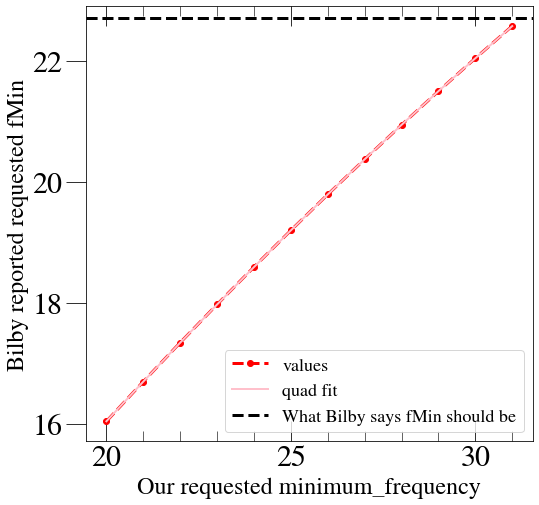

In [7]:
def BilbyMinimumFrequency():
    
    sur_fmin = [20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0]
    bil_fmin = [16.04293095, 16.69953829, 17.34314270, 17.97386363, 18.59182733, 19.19716692, 19.79002226, 20.37053975, \
              20.93887207, 21.49517785, 22.03962128, 22.57237175]
    ## Fit a relationship between the two
    fit = np.polyfit(sur_fmin, bil_fmin, 2)
    p = np.poly1d(fit)
    
    ## What the f_min should be for the run specified above
    fmin_should = 22.70617355 
    

    plt.figure(figsize=(8,8))

    plt.plot(sur_fmin, bil_fmin, '--o', color='red', label = 'values')
    plt.plot(sur_fmin, p(sur_fmin), label = 'quad fit', lw = 2.0, color = 'pink')

    plt.xlabel('Our requested minimum_frequency')
    plt.ylabel('Bilby reported requested fMin')

    plt.axhline(fmin_should, color='black', ls = '--', label = 'What Bilby says fMin should be')

    plt.legend()

    plt.show()

BilbyMinimumFrequency()